In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp, solve_ivp
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import hamhelper.plotting as hp

Solution successful!
Control cost J for τ = 6.283 is 2.546480


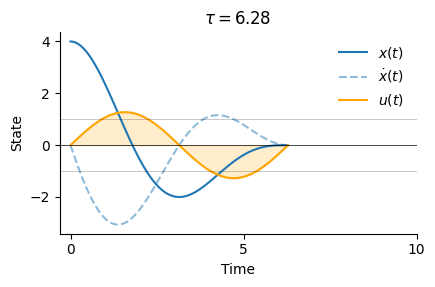

Solution successful!
Control cost J for τ = 7.500 is 2.261506


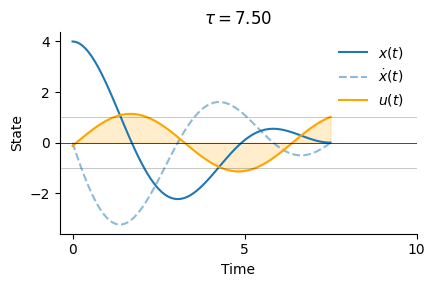

Solution successful!
Control cost J for τ = 11.000 is 1.466178


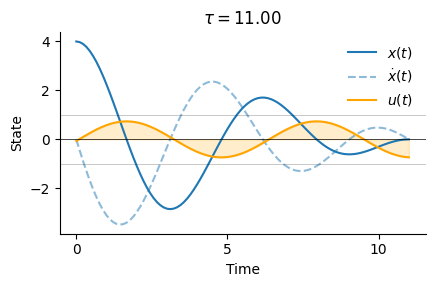

Solution successful!
Control cost J for τ = 50.000 is 0.318482


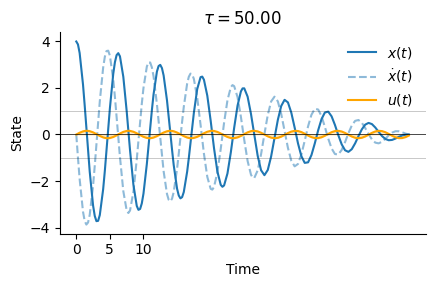

Solution successful!
Control cost J for τ = 100.000 is 0.159114


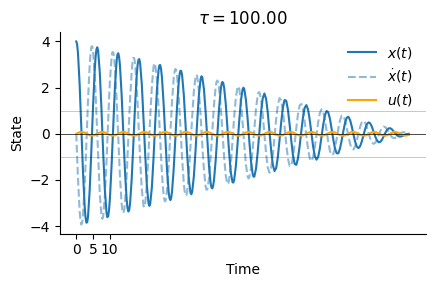

Fix me!
Control cost J for τ = 1000.000 is 0.016875


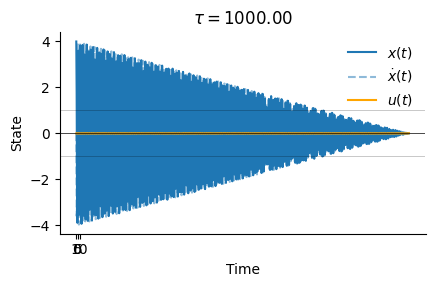

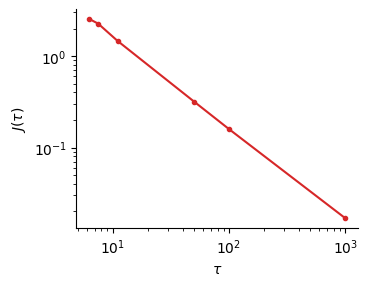

In [147]:
# Define the ODE system
def dynamics(t, y):
    # From part (b)
    x1, x2, l1, l2 = y
    dx1dt =     x2
    dx2dt = -x1       - l2
    dl1dt =        l2
    dl2dt =           - l1
    return np.array([dx1dt, dx2dt, dl1dt, dl2dt])

def boundary_cond(ya, yb):
    x1a, x2a, _, _ = ya  # Using x and x' not lambdas
    x1b, x2b, _, _ = yb
    # want this boundary condition to evalauate to 0 at the start then end
    return np.array([
        x1a - 4,    # x1(0) = x0 = 4  initial
        x2a - 0,    # x2(0) = 0
        x1b - 0,    # x1(tau) = 0     final
        x2b - 0])   # x2(tau) = 0
    

# Initial linspace and guess
def solve_for_tau(tau):
    t = np.linspace(0, tau, 100)
    y_guess = np.zeros((4, t.size))
    y_guess[0] = 0  # y=const guess

    # Solve BVP
    sol = solve_bvp(dynamics, boundary_cond, t, y_guess)
    if sol.success:
        print(f"Solution successful!")
    else:
        print("Fix me!")

    return sol

# Example for tau = 2pi, and others to show 1/tau relationship in J
taus = [2 * np.pi, 7.5, 11, 50, 100, 1000]
J_arr = []

for tau in taus:
    sol = solve_for_tau(tau)
    # Compute the control input u(t) = -lambda_2(t)
    u = -sol.y[3]  # lambda_2 is the 4th row

    # Compute the cost using trap integral
    J = 0.5 * np.trapz(u**2, sol.x)
    J_arr.append(J)
    print(f"Control cost J for τ = {tau:.3f} is {J:.6f}")

    # Extract solution
    t_vals = sol.x
    x1, x2, l1, l2 = sol.y
    u = -l2

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=np.array([3.3, 2.2])*1.35)
    ax.plot(t_vals, x1, label=r'$x(t)$', color='C0')
    ax.plot(t_vals, x2, label=r'$\dot{x}(t)$', color='C0', linestyle='--', alpha=0.5)
    ax.plot(t_vals, u, color='orange', label=r'$u(t)$')
    ax.fill_between(t_vals, u, 0, color='orange', alpha=0.2)
    
    ax.axhline(0, color='k', lw=0.5)
    ax.axhline(1, color='k', lw=0.5, alpha=0.3)
    ax.axhline(-1, color='k', lw=0.5, alpha=0.3)
    
    ax.set(xlabel='Time', ylabel='State', title=r'$\tau = $' + f'{tau:.2f}',
           xticks=[0, 5, 10])
    hp.despine(ax)
    plt.legend(framealpha=0)
    plt.tight_layout()
    plt.savefig(f'plots/q1_c_tau_{tau:.2f}.pdf', bbox_inches='tight')
    plt.savefig(f'plots/q1_c_tau_{tau:.2f}.png', bbox_inches='tight')
    plt.show()

# plot J relationship
fig, ax = plt.subplots(1, 1, figsize=np.array([2.8, 2.2])*1.35)
ax.plot(taus, J_arr, marker='.', color='C3')
ax.set(xlabel=r'$\tau$', ylabel=r'$J(\tau)$')
ax.set_xscale('log')
ax.set_yscale('log')
hp.despine(ax)

plt.tight_layout()
plt.savefig(f'plots/q1_e.pdf', bbox_inches='tight')
plt.savefig(f'plots/q1_e.png', bbox_inches='tight')
plt.show()


## (f)

Cost with fixed final state: J = 10.466
Cost with free final state:  J = 9.961


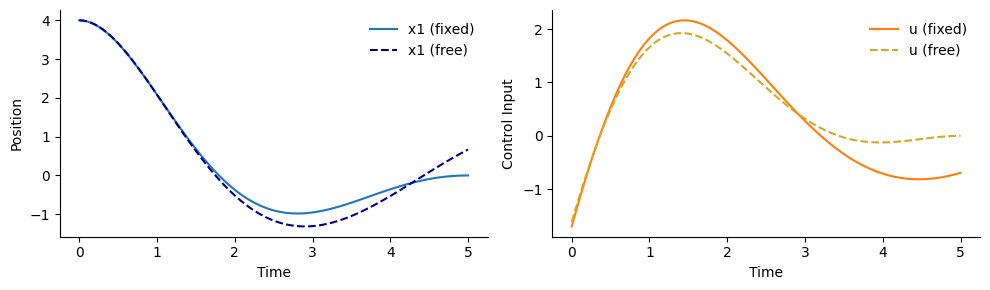

In [ ]:
# System dynamics for modified cost L = 0.5*(x^2 + u^2)
def dynamics(t, y):
    x1, x2, l1, l2 = y
    dx1dt =     x2
    dx2dt = -x1        -l2  # u=-l2
    dl1dt = -x1        +l2 
    dl2dt =        -l1
    return np.array([dx1dt, dx2dt, dl1dt, dl2dt])

# Case A: Fixed final state boundary conditions
def bc_case_a(ya, yb):
    x1a, x2a, _, _ = ya  # only BC on x
    x1b, x2b, _, _ = yb
    return np.array([x1a - 4, x2a, x1b, x2b])

# Case B: Free final state, zero costate at final time
def bc_case_b(ya, yb):
    x1a, x2a, _, _ = ya  # BC on lambdas
    _, _, l1b, l2b = yb
    return np.array([x1a - 4, x2a, l1b, l2b])

def solve_bvp_case(tau, bc_func, resolution=100):
    t = np.linspace(0, tau, resolution)
    y_guess = np.zeros((4, t.size))
    y_guess[0] = 0
    return solve_bvp(dynamics, bc_func, t, y_guess)

# Solve both
tau = 5
sol_a = solve_bvp_case(tau, bc_case_a)
sol_b = solve_bvp_case(tau, bc_case_b)

# Extract solution
t_vals = sol_a.x
x1_a, x2_a, _, l2_a = sol_a.y
x1_b, x2_b, _, l2_b = sol_b.y
u_a = -l2_a
u_b = -l2_b

# Compute costs as integral sum
J_a = 0.5 * np.trapz(x1_a**2 + u_a**2, t_vals)
J_b = 0.5 * np.trapz(x1_b**2 + u_b**2, t_vals)

# Print costs
print(f"Cost with fixed final state: J = {J_a:.3f}")
print(f"Cost with free final state:  J = {J_b:.3f}")

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(t_vals, x1_a, label='x1 (fixed)', color='C0')
ax1.plot(t_vals, x1_b, label='x1 (free)', color='darkblue', linestyle='--')
ax1.set(xlabel = "Time", ylabel = "Position")
ax1.legend(framealpha=0)
hp.despine(ax1)

ax2.plot(t_vals, u_a, label='u (fixed)', color='C1')
ax2.plot(t_vals, u_b, label='u (free)', color='goldenrod', linestyle='--')
ax2.set(xlabel="Time", ylabel="Control Input")
ax2.legend(framealpha=0)
hp.despine(ax2)

plt.tight_layout()
plt.savefig(f'plots/q1_f_{tau:.2f}.pdf', bbox_inches='tight')
plt.savefig(f'plots/q1_f_{tau:.2f}.png', bbox_inches='tight')
plt.show()

# Q2
## (a)

Control cost J for τ = 6.284 is 3.134464


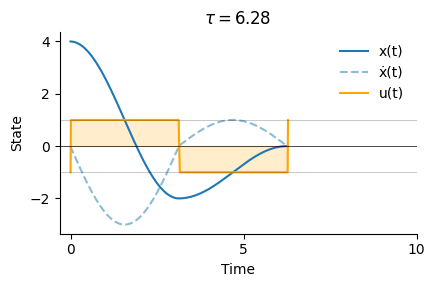

Control cost J for τ = 7.500 is 2.282779


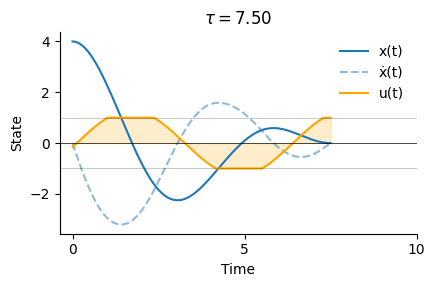

Control cost J for τ = 11.000 is 1.466101


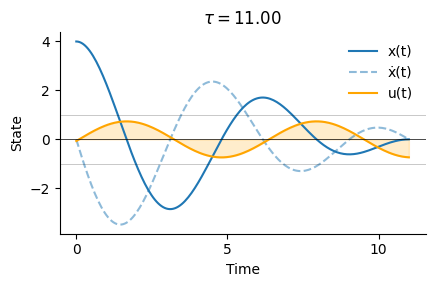

Control cost J for τ = 50.000 is 0.318370


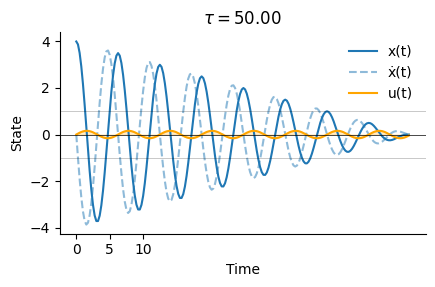

Control cost J for τ = 100.000 is 0.159373


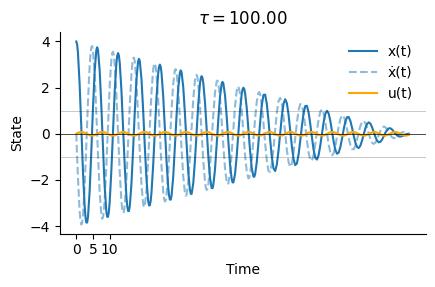

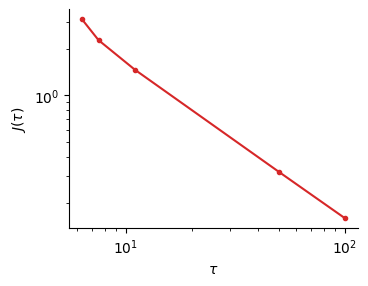

In [149]:
def constrained_dynamics(t, y):
    x1, x2, l1, l2 = y
    u = np.clip(-l2, -1, 1)  # clip the u
    dx1 =     x2
    dx2 = -x1          +u
    dl1 =           l2
    dl2 =       -l1
    return np.array([dx1, dx2, dl1, dl2])

# Boundary conditions unchanged
# Solve BVP for given τ
def solve_constrained_bvp(tau):
    t = np.linspace(0, tau, 200)
    y_guess = np.zeros((4, t.size))
    y_guess[0] = 0
    sol = solve_bvp(constrained_dynamics, boundary_cond, t, y_guess)
    return sol

# Add a small offset from 2pi to avoid singularity
taus = [2 * np.pi + 0.001, 7.5, 11, 50, 100]
J_arr = []
for tau in taus:
    sol = solve_constrained_bvp(tau)
    t_vals = sol.x
    x1, x2, _, l2 = sol.y
    u = np.clip(-l2, -1, 1)
    # Compute the cost using trap-integral
    J = 0.5 * np.trapz(u**2, sol.x)
    J_arr.append(J)
    print(f"Control cost J for τ = {tau:.3f} is {J:.6f}")

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=np.array([3.3, 2.2])*1.35)
    ax.plot(t_vals, x1, label='x(t)', color='C0')
    ax.plot(t_vals, x2, label='ẋ(t)', color='C0', linestyle='--', alpha=0.5)
    ax.plot(t_vals, u, color='orange', label='u(t)')
    ax.fill_between(t_vals, u, 0, color='orange', alpha=0.2)
    # ax.plot(t_vals, l2, label='l2', color='C2')
    
    ax.axhline(0, color='k', lw=0.5)
    ax.axhline(1, color='k', lw=0.5, alpha=0.3)
    ax.axhline(-1, color='k', lw=0.5, alpha=0.3)
    
    ax.set(xlabel='Time', ylabel='State', title=r'$\tau = $' + f'{tau:.2f}',
           xticks=[0, 5, 10],)
    hp.despine(ax)
    plt.legend(framealpha=0)
    plt.tight_layout()
    plt.savefig(f'plots/q2_a_tau_{tau:.2f}.pdf', bbox_inches='tight')
    plt.savefig(f'plots/q2_a_tau_{tau:.2f}.png', bbox_inches='tight')
    plt.show()


# plot J relationship
fig, ax = plt.subplots(1, 1, figsize=np.array([2.8, 2.2])*1.35)
ax.plot(taus, J_arr, marker='.', color='C3')
ax.set(xlabel=r'$\tau$', ylabel=r'$J(\tau)$')
ax.set_xscale('log')
ax.set_yscale('log')
hp.despine(ax)

plt.tight_layout()
plt.savefig(f'plots/q2_b.pdf', bbox_inches='tight')
plt.savefig(f'plots/q2_b.png', bbox_inches='tight')
plt.show()

# todo: plot l2

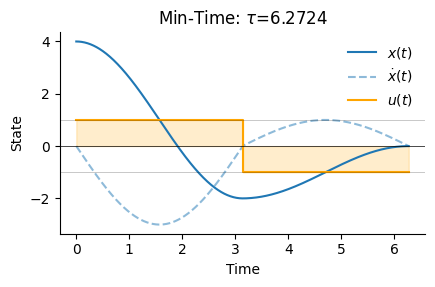

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


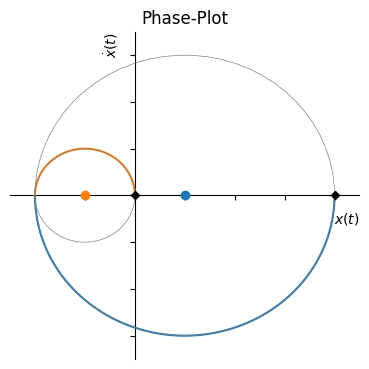

In [ ]:
# Now use solve_ivp to solve minimal time
# System dynamics with constant control u
def min_time_dynamics(t, y, u):
    x1, x2 = y
    dx1 =     x2
    dx2 = -x1    +u
    return [dx1, dx2]

# Simulate trajectory with single switching at ts for bang-bang
def simulate(ts, tau, x0=4.0, resolution=1000):
    t_eval1 = np.linspace(0,  ts,  int(resolution * ts         / tau))
    t_eval2 = np.linspace(ts, tau, int(resolution * (tau - ts) / tau))
    # Segment 1
    sol1 = solve_ivp(min_time_dynamics, [0, ts], [x0, 0], args=(1), dense_output=True, t_eval=t_eval1)
    x1_end = sol1.y[:, -1]
    # Segment 2
    sol2 = solve_ivp(min_time_dynamics, [ts, tau], x1_end, args=(-1,), dense_output=True, t_eval=t_eval2)

    # Combine time and state
    t_all  = np.concatenate([sol1.t, sol2.t])
    x1_all = np.concatenate([sol1.y[0], sol2.y[0]])
    x2_all = np.concatenate([sol1.y[1], sol2.y[1]])
    u_all  = np.concatenate([np.ones_like(sol1.t), 
                             -np.ones_like(sol2.t)])
    
    return t_all, x1_all, x2_all, u_all, sol2.y[:, -1]

# Cost function: terminal error magnitude
# This is what we give to minimize
def objective(params):
    ts, tau = params
    if ts <= 0 or tau <= ts:
        return 1e6  # invalid
    _, _, _, _, xf = simulate(ts, tau)  # xf is what we want to minimize
    return np.linalg.norm(xf)

# Solve for optimal switching time and duration
y0 = [3, 6]
result = minimize(objective, y0, bounds=[(0.1, 10), (0.2, 20)])  # est bounds
ts_opt, tau_opt = result.x
t, x1, x2, u, _ = simulate(ts_opt, tau_opt, resolution=1000)

# Plot
fig, ax = plt.subplots(1, 1, figsize=np.array([3.3, 2.2]) * 1.35)
ax.plot(t, x1, label='$x(t)$', color='C0')
ax.plot(t, x2, label=r'$\dot{x}(t)$', color='C0', linestyle='--', alpha=0.5)
ax.plot(t, u, label='$u(t)$', color='orange')
ax.fill_between(t, u, 0, color='orange', alpha=0.2)

ax.axhline(0, color='k', lw=0.5)
ax.axhline(1, color='k', lw=0.5, alpha=0.3)
ax.axhline(-1, color='k', lw=0.5, alpha=0.3)
ax.set(xlabel='Time', ylabel='State', title=rf'Min-Time $\tau$={tau_opt:.4f}')
ax.legend(framealpha=0)
hp.despine(ax)
plt.tight_layout()
plt.savefig('plots/q3_bangbang.pdf', bbox_inches='tight')
plt.savefig('plots/q3_bangbang.png', bbox_inches='tight')
plt.show()

# Phase-space plot
fig, ax = plt.subplots(figsize=np.array([3.3, 3.3]) * 1.15)

# Move spines to origin according to https://github.com/rougier/matplotlib-tutorial
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data',0))
ax.spines['bottom'].set_zorder(0)
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data',0))
ax.spines['left'].set_zorder(0)

ax.plot(x1[np.where(x2<0)][:-1], x2[np.where(x2<0)][:-1], color='C0')
ax.plot(x1[np.where(x2>0)], x2[np.where(x2>0)], color='C1')
# blue dot at x=1 and orange dot at x=-1
ax.plot(1, 0, 'o', color='C0')
ax.plot(-1, 0, 'o', color='C1')
# thin grey circle centered at x=1 with rad 3 and circle centered at x=-1 wwith radius 1
circle1 = plt.Circle((1, 0), 3, color='grey', fill=False, lw=0.5, zorder=10)
circle2 = plt.Circle((-1, 0), 1, color='grey', fill=False, lw=0.5, zorder=10)
ax.add_artist(circle1)
ax.add_artist(circle2)

# start and end black diamonds
ax.plot(x1[0], x2[0], 'D', color='black', markersize=4, zorder=20)
ax.plot(x1[-1], x2[-1], 'D', color='black', markersize=4, zorder=20)

ax.set(title = "Phase-Plot", xlim=[-2.5, 4.5], ylim=[-3.5,3.5])

ax.set_xticklabels([])
ax.set_xlabel(r'$x(t)$', loc='right')
ax.set_ylabel(r"$\dot{x}(t)$", loc='top')
ax.set_yticklabels([])
ax.legend(framealpha=0)
plt.tight_layout()
plt.savefig('plots/q3_phase_space.pdf', bbox_inches='tight')
plt.savefig('plots/q3_phase_space.png', bbox_inches='tight')
plt.show()

# Q4
## (c) Riccati sim

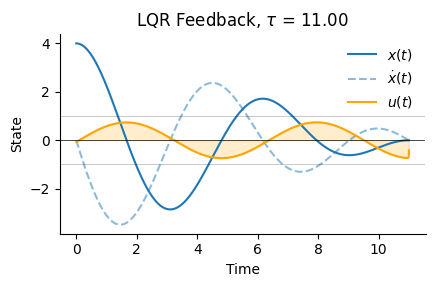

In [ ]:
def riccati_dynamics(t, y):
    # Use the S variables now
    S11, S12, S22 = y
    dS11dt =  2*S12 + S12**2
    dS12dt = S22 - S11 + S12*S22
    dS22dt = -2*S12 + S22**2
    # return negative because we want solve IVP in reverse
    return [dS11dt, dS12dt, dS22dt]

def solve_riccati(tau, S_inf=1e5, resolution=8000):
    t_span = [tau, 0]
    y0 = [S_inf, 0, S_inf]
    sol = solve_ivp(riccati_dynamics,
                    t_span,
                    y0,  # Start with moderate value
                    t_eval=np.linspace(tau, 0, resolution),
                    method='Radau')
    return sol

def simulate_feedback(t, S, x0=4.0):
    S11, S12, S22 = S  # unpack
    x = np.zeros((2, len(t)))
    u = np.zeros(len(t))
    x[:, 0] = [x0, 0]

    for i in range(1, len(t)):
        dt = t[i] - t[i-1]
        K = np.array([S12[i], S22[i]])  # K(t)
        u[i-1] = -K @ x[:, i-1]  # control
        dx1 = x[1, i-1]
        dx2 = -x[0, i-1] + u[i-1]  # apply control
        x[0, i] = x[0, i-1] + dt * dx1
        x[1, i] = x[1, i-1] + dt * dx2

    # Final control input
    u[-1] = -np.array([S12[-1], S22[-1]]) @ x[:, -1]
    return x, u

# Initial values
tau = 11
riccati_sol = solve_riccati(tau)
t_vals = riccati_sol.t[::-1]
S11 = riccati_sol.y[0][::-1]  # Plot these later
S12 = riccati_sol.y[1][::-1]
S22 = riccati_sol.y[2][::-1]

# Run dynamics with the solved S(t)'s
x, u = simulate_feedback(t_vals, (S11, S12, S22))
t_vals_lqr = t_vals[:-1]
x1_lqr = x[0,:-1]
x2_lqr = x[1,:-1]
u_lqr = u[:-1]

# Plot
fig, ax = plt.subplots(1, 1, figsize=np.array([3.3, 2.2]) * 1.35)
ax.plot(t_vals_lqr, x1_lqr, label=r'$x(t)$', color='C0')
ax.plot(t_vals_lqr, x2_lqr, label=r'$\dot{x}(t)$', color='C0', linestyle='--', alpha=0.5)
ax.plot(t_vals_lqr, u_lqr, color='orange', label=r'$u(t)$')
ax.fill_between(t_vals_lqr, u_lqr, 0, color='orange', alpha=0.2)
ax.axhline(0, color='k', lw=0.5)
ax.axhline(1, color='k', lw=0.5, alpha=0.3)
ax.axhline(-1, color='k', lw=0.5, alpha=0.3)
ax.set(xlabel='Time', ylabel='State', title=rf'LQR Feedback, $\tau$ = {tau:.2f}')
ax.legend(framealpha=0)
hp.despine(ax)
plt.tight_layout()
plt.savefig(f'plots/lqr_tau_{tau:.2f}.pdf', bbox_inches='tight')
plt.savefig(f'plots/lqr_tau_{tau:.2f}.png', bbox_inches='tight')
plt.show()

# Q5
## (A)

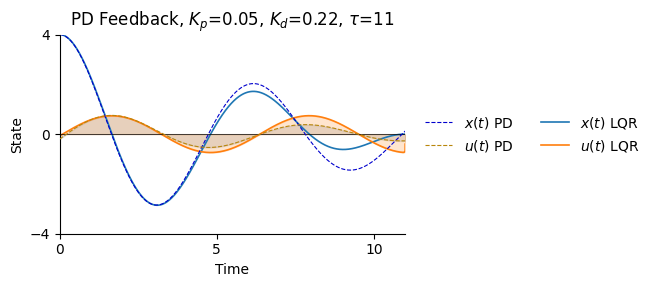

In [ ]:
def pd_dynamics(t, y):
    x, xdot = y  # unpack state variables
    u = -Kp * x - Kd * xdot  # PD control
    dxdt = xdot
    dxdotdt = -x + u  # update dynamics
    return [dxdt, dxdotdt]
    
def simulate_PD(Kp, Kd, tau=11, resolution=1000):
    # state space
    t_span = [0, tau]
    t_eval = np.linspace(0, tau, resolution)
    # IVp solve
    y0 = [4.0, 0.0]
    sol = solve_ivp(pd_dynamics, t_span, y0, t_eval=t_eval, rtol=1e-8, atol=1e-8)
    # Extract solution
    x = sol.y[0]
    xdot = sol.y[1]
    u = -Kp * x - Kd * xdot
    return sol.t, x, xdot, u

# Sim and plot
Kp, Kd = 0.05, 0.22  # Manualy adjusted
t_pd, x_pd, xdot_pd, u_pd = simulate_PD(Kp, Kd, tau=11, resolution=1000)

fig, ax = plt.subplots(1, 1, figsize=np.array([3.3*1.5, 2.2]) * 1.35)
ax.plot(t_pd, x_pd, label=r'$x(t)$ PD', color='mediumblue', linestyle='--', zorder=10, lw=0.8)
# ax.plot(t_pd, xdot_pd, label='ẋ(t) PD', color='C0', linestyle='--', alpha=0.5)
ax.plot(t_pd, u_pd, color='darkgoldenrod', label=r'$u(t)$ PD', linestyle='--', zorder=10, lw=0.8)
ax.fill_between(t_pd, u_pd, 0, color='slategrey', alpha=0.2)

ax.plot(t_vals_lqr, x1_lqr, label=r'$x(t)$ LQR', color='C0', linestyle='-', lw=1.2)
ax.plot(t_vals_lqr, u_lqr, color='C1', label=r'$u(t)$ LQR', linestyle='-', lw=1.2)
ax.fill_between(t_vals_lqr, u_lqr, 0, color='C1', alpha=0.2)

ax.axhline(0, color='k', lw=0.5)
ax.set(xlabel='Time', ylabel='State', xticks=[0, 5, 10], yticks=[-4, 0, 4],
       title=rf'PD Feedback, $K_p$={Kp}, $K_d$={Kd}, $\tau$={11}',
       xlim=[0, 11], ylim=[-4, 4])
ax.legend(framealpha=0, ncol=2, loc='center left', bbox_to_anchor=(1.02, 0.5))
hp.despine(ax)
plt.tight_layout()
plt.savefig(f'plots/5_a.pdf', bbox_inches='tight')
plt.savefig(f'plots/5_a.png', bbox_inches='tight')
plt.show()

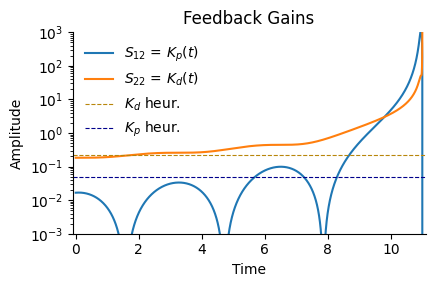

In [ ]:
# plot gains (from 4)
fig, ax = plt.subplots(1, 1, figsize=np.array([3.3, 2.2]) * 1.35)
# ax.plot(t_vals, S11[:-1], label=r'$S_{11}$', color='C2')
ax.plot(t_vals, S12, label=r'$S_{12}$ = $K_p(t)$', color='C0')
ax.plot(t_vals, S22, label=r'$S_{22}$ = $K_d(t)$', color='C1')
ax.axhline(0, color='k', lw=0.5)

ax.axhline(Kd, color='darkgoldenrod', ls='--', lw=0.8, label=r'$K_d$ heur.')
ax.axhline(Kp, color='darkblue', ls='--', lw=0.8, label=r'$K_p$ heur.')

ax.set(xlabel='Time', ylabel='Amplitude', ylim=[1e-3, 1e3], title='Feedback Gains',
       xlim=[-0.1, 11.1])
ax.set_yscale('log')
ax.legend(framealpha=0)
hp.despine(ax)
plt.tight_layout()
plt.savefig(f'plots/lqr_S_tau_{tau:.2f}.pdf', bbox_inches='tight')
plt.savefig(f'plots/lqr_S_tau_{tau:.2f}.png', bbox_inches='tight')
plt.show()